In [ ]:
#installing required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import time
import os
import shutil
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
import random
from IPython.display import clear_output

In [ ]:
#mounting content from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#listing content the in the selected google drive directory
!ls /content/drive/MyDrive/casia

Au  au_list.txt  test  Tp  tp_list.txt	train  val


In [ ]:
# Defining the paths to the folder containing the datasets
data_dir = '/content/drive/MyDrive/casia'
authentic_path = '/content/drive/MyDrive/casia/Au'
forged_path = '/content/drive/MyDrive/casia/Tp'
train_dir = '/content/drive/MyDrive/casia/train'
val_dir = '/content/drive/MyDrive/casia/val'
test_dir = '/content/drive/MyDrive/casia/test'


In [ ]:
#function for applying ELA to images
def convert_to_ela_image(data_dir, quality):
    original_image = Image.open(data_dir).convert('RGB')
    resaved_file_name = 'resaved_image.jpg'
    original_image.save(resaved_file_name, 'JPEG', quality=quality)
    resaved_image = Image.open(resaved_file_name)
    ela_image = ImageChops.difference(original_image, resaved_image)
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference == 0:
        max_difference = 1
    scale = 350.0 / max_difference
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    ela_image.save("ela_image.png")
    return ela_image

In [ ]:
#data augmentation transformations definition
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

In [ ]:
# Initializing lists to store images and labels
X = []  # ELA converted images
Y = []  # 0 for forged, 1 for authentic
filenames = []  # To store the filenames


def prepare_ela_image(image_path, quality=90, target_size=(128, 128)):
    ela_image = convert_to_ela_image(image_path, quality)
    ela_image = ela_image.resize(target_size)
    return np.array(ela_image)

# Adding forged images with ELA conversion
for filename in tqdm(os.listdir(forged_path), desc="Processing Forged Images"):
    if filename.endswith('jpg') or filename.endswith('bmp') :
        full_path = os.path.join(forged_path, filename)
        X.append(prepare_ela_image(full_path))
        Y.append(0)  # Label for forged images
        filenames.append(filename)

# Adding authentic images with ELA conversion
for filename in tqdm(os.listdir(authentic_path), desc="Processing Authentic Images"):
    if filename.endswith('jpg') or filename.endswith('tif'):
        full_path = os.path.join(authentic_path, filename)
        X.append(prepare_ela_image(full_path))
        Y.append(1)  # Label for authentic images
        filenames.append(filename)

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Check the shape of the images
print(f'Image shape: {X.shape[1:]}')

Processing Authentic Images: 100%|██████████| 7545/7545 [08:34<00:00, 14.66it/s]


Image shape: (128, 128, 3)


In [ ]:
# Initial split with stratification
X_temp, X_test, Y_temp, Y_test, filenames_temp, filenames_test = train_test_split(
    X, Y, filenames, test_size=0.05, random_state=5, stratify=Y
)

# split the remaining data further into training and validation sets
X_train, X_val, Y_train, Y_val, filenames_train, filenames_val = train_test_split(
    X_temp, Y_temp, filenames_temp, test_size=0.2, random_state=5, stratify=Y_temp
)

# Function to balance the test set
def balance_classes(X, Y, filenames):
    class_indices = {label: np.where(Y == label)[0] for label in np.unique(Y)}
    min_class_count = min(len(indices) for indices in class_indices.values())

    balanced_indices = []
    for indices in class_indices.values():
        balanced_indices.extend(np.random.choice(indices, min_class_count, replace=False))

    balanced_indices = np.array(balanced_indices)
    return X[balanced_indices], Y[balanced_indices], [filenames[i] for i in balanced_indices]

# Balance the test set
X_test_balanced, Y_test_balanced, filenames_test_balanced = balance_classes(X_test, Y_test, filenames_test)

# # Create directories to store split datasets
# train_dir = '/content/drive/MyDrive/casia/train'
# val_dir = '/content/drive/MyDrive/casia/val'
# test_dir = '/content/drive/MyDrive/casia/test'

# # Create the directories if they don't exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

In [ ]:
# def is_valid_image(file_path):
#     try:
#         with Image.open(file_path) as img:
#             img.verify()
#         return True
#     except (IOError, SyntaxError):
#         return False

# # Function to save images to respective directories
# def save_images(images, labels, filenames, directory):
#     for img, label, filename in zip(images, labels, filenames):
#         src_path = os.path.join(forged_path if label == 0 else authentic_path, filename)
#         dst_path = os.path.join(directory, filename)

#         # Check if the source file exists and is a valid image
#         if os.path.exists(src_path) and is_valid_image(src_path):
#             print(f'Copying from {src_path} to {dst_path}')  # Debugging print statement
#             try:
#                 shutil.copy(src_path, dst_path)
#             except Exception as e:
#                 print(f'Error copying {src_path} to {dst_path}: {e}')  # Error handling
#         else:
#             print(f'Source file {src_path} does not exist or is not a valid image.')

# # Save training images
# save_images(X_train, Y_train, filenames_train, train_dir)

# # Save validation images
# save_images(X_val, Y_val, filenames_val, val_dir)

# # Save test images
# save_images(X_test, Y_test, filenames_test, test_dir)

# # Print dataset sizes
# print(f'Training images: {len(X_train)} , Training labels: {len(Y_train)}')
# print(f'Validation images: {len(X_val)} , Validation labels: {len(Y_val)}')
# print(f'Test images: {len(X_test)} , Test labels: {len(Y_test)}')

# print(f'Training images stored in: {train_dir}')
# print(f'Validation images stored in: {val_dir}')
# print(f'Test images stored in: {test_dir}')

In [ ]:
#convert to tensors to match pytorchs expectation

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Load the pretrained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze all the parameters in the model
for param in model.parameters():
    param.requires_grad = True

# Get the number of input features to the classifier
num_ftrs = model.classifier[6].in_features

# Replace the final layer of the classifier with a new layer for binary classification
model.classifier[6] = nn.Linear(num_ftrs, 2)

# Ensure the final layer's parameters require gradients
for param in model.classifier[6].parameters():
    param.requires_grad = True

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Assuming Y_train is your training labels tensor
# If Y_train is a PyTorch tensor, convert it to a NumPy array
if isinstance(Y_train, torch.Tensor):
    Y_train = Y_train.numpy()

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Move class weights to the same device

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define the optimizer
optimizer = optim.Adam(model.classifier[6].parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 194MB/s]


In [ ]:
# Function to display transformed images
def display_images_transform(original, transformed, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transformed.permute(1, 2, 0))  # Convert from tensor to image format
    plt.title('Transformed Image')
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

In [ ]:
# Insert index of any image from each class
original_image_path = os.path.join(authentic_path, os.listdir(authentic_path)[333])
# authentic_image_path = os.path.join(authentic_path, os.listdir(authentic_path)[2])

# Load images
original_image = Image.open(original_image_path).convert('RGB')
# authentic_image = Image.open(authentic_path).convert('RGB')

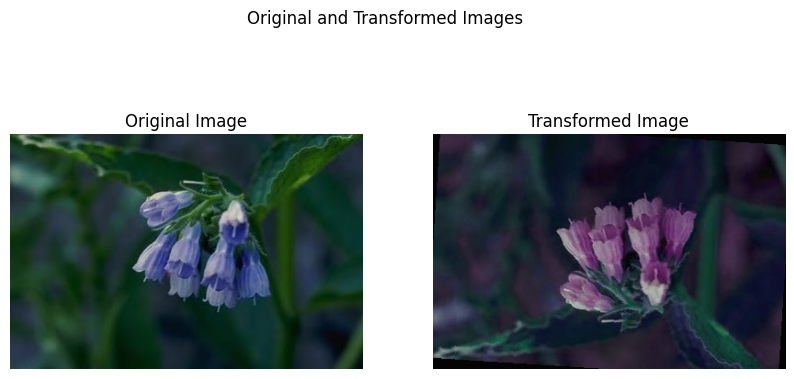

In [ ]:

# Apply transformations
transformed_image = transform(original_image)

# Display original and transformed images
display_images_transform(original_image, transformed_image, "Original and Transformed Images")

In [ ]:
def display_images_ela(original, ela, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(ela)
    plt.title('ELA Image')
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

In [ ]:
# Give the index of any image from each class
forged_image_path = os.path.join(forged_path, os.listdir(forged_path)[550])
authentic_image_path = os.path.join(authentic_path, os.listdir(authentic_path)[383])

# Load images
forged_image = Image.open(forged_image_path).convert('RGB')
authentic_image = Image.open(authentic_image_path).convert('RGB')

In [ ]:
# Convert images to ELA
forged_ela_image = convert_to_ela_image(forged_image_path, 90)
authentic_ela_image = convert_to_ela_image(authentic_image_path, 90)

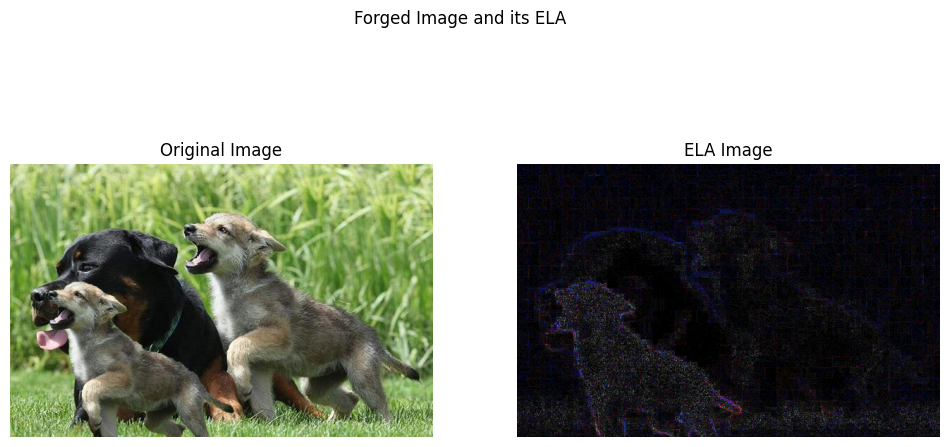

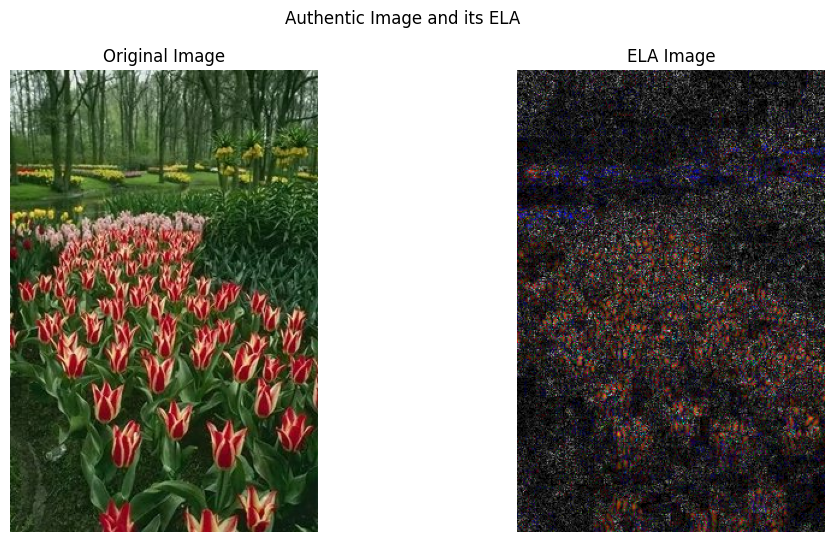

In [ ]:
# Display images
display_images_ela(forged_image, forged_ela_image, "Forged Image and its ELA")
display_images_ela(authentic_image, authentic_ela_image, "Authentic Image and its ELA")

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

In [ ]:
def evaluate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(val_loader), 100 * correct / total

In [ ]:
import copy

# Define early stopping parameters
patience = 5  # Number of epochs to wait before stopping
best_val_loss = float('inf')
early_stopping_counter = 0
best_model_state_dict = None

In [ ]:
num_epochs = 50
# lr = 1e-4

In [ ]:
# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies, val_accuracies = [], []

# Record the start time
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_acc:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_acc = correct_val / total_val
    val_accuracies.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        best_model_state_dict = copy.deepcopy(model.state_dict())
    else:
        early_stopping_counter += 1

    # Stop training if validation loss hasn't improved for `patience` epochs
    if early_stopping_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Record the end time
end_time = time.time()

# Calculate the total time taken
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch 1/50, Training Loss: 1.5225, Training Accuracy: 0.6126
Epoch 1/50, Validation Loss: 0.6676, Validation Accuracy: 0.5848
Epoch 2/50, Training Loss: 0.9959, Training Accuracy: 0.6735
Epoch 2/50, Validation Loss: 0.4700, Validation Accuracy: 0.7660
Epoch 3/50, Training Loss: 0.8273, Training Accuracy: 0.7016
Epoch 3/50, Validation Loss: 0.4506, Validation Accuracy: 0.7786
Epoch 4/50, Training Loss: 0.7026, Training Accuracy: 0.7190
Epoch 4/50, Validation Loss: 0.4450, Validation Accuracy: 0.7687
Epoch 5/50, Training Loss: 0.6188, Training Accuracy: 0.7305
Epoch 5/50, Validation Loss: 0.4389, Validation Accuracy: 0.7957
Epoch 6/50, Training Loss: 0.6092, Training Accuracy: 0.7365
Epoch 6/50, Validation Loss: 0.4447, Validation Accuracy: 0.7555
Epoch 7/50, Training Loss: 0.5671, Training Accuracy: 0.7465
Epoch 7/50, Validation Loss: 0.4481, Validation Accuracy: 0.8254
Epoch 8/50, Training Loss: 0.5443, Training Accuracy: 0.7514
Epoch 8/50, Validation Loss: 0.4697, Validation Accuracy:

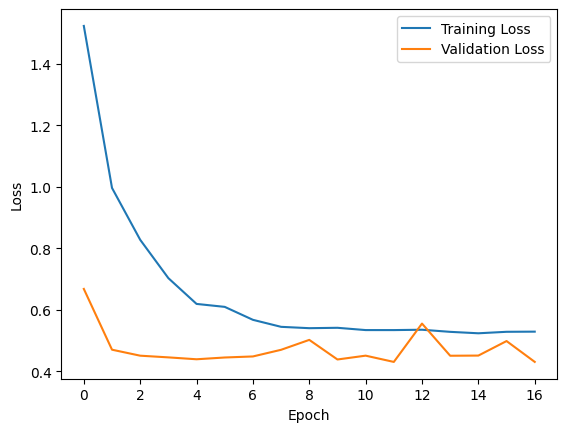

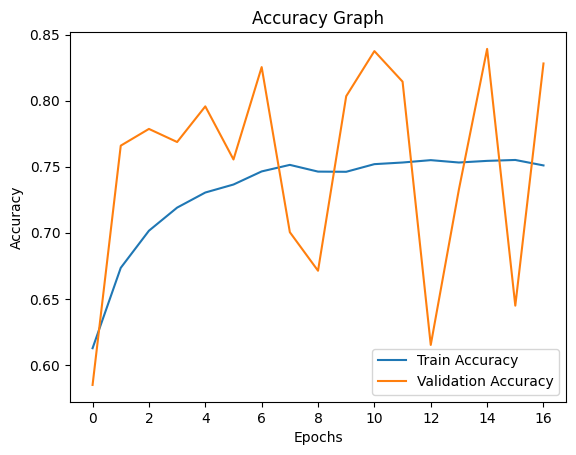

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Graph')

plt.show()

In [ ]:
test_loss, test_acc = evaluate(model, device, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Test Loss: 0.4539, Test Acc: 81.17%


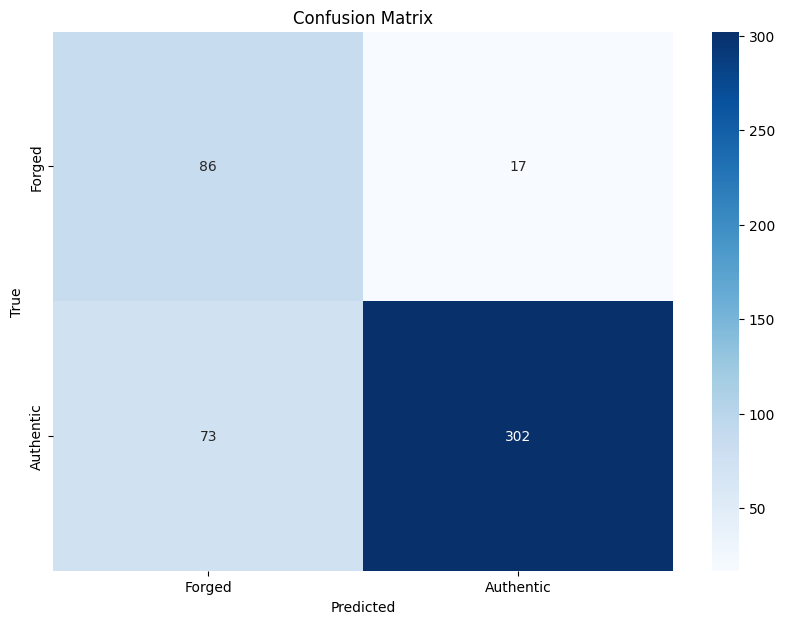

              precision    recall  f1-score   support

      Forged       0.54      0.83      0.66       103
   Authentic       0.95      0.81      0.87       375

    accuracy                           0.81       478
   macro avg       0.74      0.82      0.76       478
weighted avg       0.86      0.81      0.82       478



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forged', 'Authentic'], yticklabels=['Forged', 'Authentic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Forged', 'Authentic']))

In [ ]:
X = np.array(X)
Y = np.array(Y)

# Create a dictionary from the filenames list
filename_dict = {filename: (X[i], Y[i]) for i, filename in enumerate(filenames)}

Shape before reshape: (128, 128, 3)
Shape after reshape: (1, 128, 128, 3)
Prediction: Forged
Actual: Forged
Prediction is correct


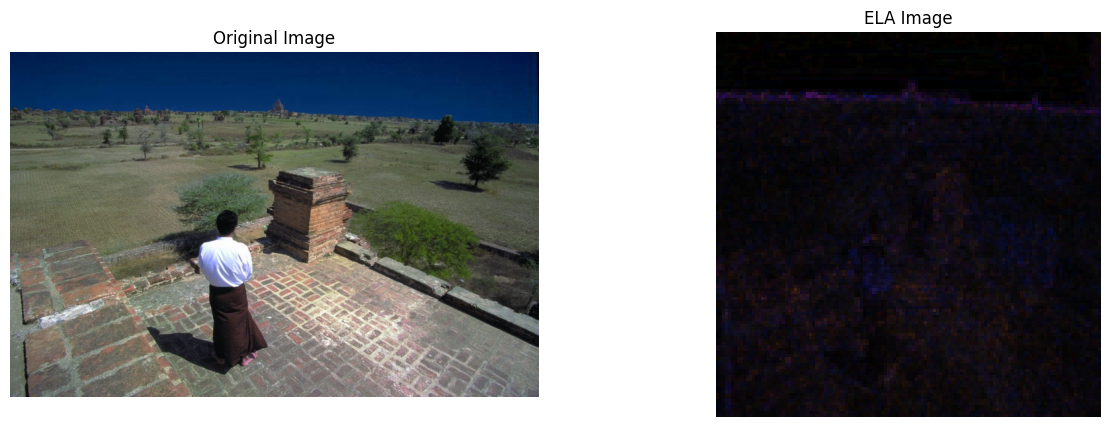

In [ ]:
# List all files in the test directory
test_image_files = os.listdir(test_dir)

# Select the first image file (or any specific image file you want to test)
test_image_path = os.path.join(test_dir, test_image_files[67])
# [2, 17, 70, 165, 166, 252, 267, 307, 344]

# Prepare the ELA image
test_image = prepare_ela_image(test_image_path)
print(f"Shape before reshape: {test_image.shape}")

# Ensure the image has the correct shape
if test_image.size != 128 * 128 * 3:
    raise ValueError(f"Unexpected image size: {test_image.size}")

test_image = test_image.reshape(-1, 128, 128, 3)
print(f"Shape after reshape: {test_image.shape}")

# Convert to tensor
test_image_tensor = torch.tensor(test_image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

# Model evaluation
model.eval()
with torch.no_grad():
    y_pred = model(test_image_tensor)
    y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

# Display images
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Display original image
original_image = plt.imread(test_image_path)
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

# Display ELA applied image
ela_image_array = convert_to_ela_image(test_image_path, 90)
ela_image_array = ela_image_array.resize((128, 128))
ela_image_array = np.array(ela_image_array)
if ela_image_array.dtype != np.float32:
    ela_image_array = ela_image_array.astype(np.float32) / 255.0
ela_image_array = np.clip(ela_image_array, 0, 1)
ax[1].axis('off')
ax[1].imshow(ela_image_array)
ax[1].set_title('ELA Image')

class_names = ['Forged', 'Authentic']
print(f'Prediction: {class_names[y_pred_class]}')

# Get the actual class label for the test image
actual_class = filename_dict.get(test_image_files[0], None)
if actual_class is None:
    print(f"Key '{test_image_files[0]}' not found in filename_dict.")
else:
    actual_label = actual_class[1]  # Extract the label from the tuple
    # Check if the prediction is correct
    is_correct = y_pred_class == actual_label
    print(f'Actual: {class_names[actual_label]}')
    print(f'Prediction is {"correct" if is_correct else "incorrect"}')

In [ ]:
class_names = ['Forged', 'Authentic']

# Testing accuracy
correct_test = 0  # correctly predicted test images
total_test = 0    # total test images

# Ensure the model is in evaluation mode
model.eval()

# Iterate over the test data
for index, image in enumerate(tqdm(X_test, desc="Processing Images : ")):
    # Reshape the image to match the input shape expected by the model
    image = image.reshape(-1, 128, 128, 3)
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

    # Make prediction
    with torch.no_grad():
        y_pred = model(image_tensor)
        y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

    # Update total test images count
    total_test += 1

    # Check if the prediction is correct
    if y_pred_class == Y_test[index]:
        correct_test += 1

# Calculate accuracy
accuracy = correct_test / total_test * 100.0
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {accuracy:.2f} %')

Processing Images : 100%|██████████| 478/478 [00:03<00:00, 158.89it/s]

Total test images: 478
Correctly predicted images: 388
Accuracy: 81.17 %


In [ ]:
from PIL import Image

# Initialize counters
authentic, forged, total = 0, 0, 0

# Define the path to the test directory
test_folder_path = '/content/drive/MyDrive/casia/test'

# Function to prepare images
def prepare_image(image_path, target_size=(128, 128)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure 3 color channels
        img = img.resize(target_size)  # Resize image
        return np.array(img)

# Iterate over files in the test directory
for filename in tqdm(os.listdir(test_folder_path), desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(test_folder_path, filename)
        test_image = prepare_image(test_image_path)
        test_image = test_image.reshape(-1, 128, 128, 3)
        test_image_tensor = torch.tensor(test_image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            y_pred = model(test_image_tensor)
            y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

        # Update counters
        total += 1
        if y_pred_class == 0:
            forged += 1
        else:
          authentic += 1

# Print results
print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')

Processing Images : 100%|██████████| 478/478 [00:08<00:00, 58.02it/s]

Total images: 478
Authentic Images: 445
Forged Images: 33


In [ ]:
# Initialize counters and lists
authentic, forged, total = 0, 0, 0
forged_indices = []  # Initialize the list to store indices of forged images

# Function to prepare images
def prepare_image(image_path, target_size=(128, 128)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure 3 color channels
        img = img.resize(target_size)  # Resize image
        return np.array(img)

# Iterate over files in the test directory
for index, filename in enumerate(tqdm(os.listdir(test_folder_path), desc="Processing Images : ")):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(test_folder_path, filename)
        test_image = prepare_image(test_image_path)
        test_image = test_image.reshape(-1, 128, 128, 3)
        test_image_tensor = torch.tensor(test_image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            y_pred = model(test_image_tensor)
            y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

        # Update counters and store indices
        total += 1
        if y_pred_class == 0:
            forged += 1
            forged_indices.append(index)
        else:
            authentic += 1

# Print results
print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')
print(f'Indices of forged images: {forged_indices}')

Processing Images : 100%|██████████| 478/478 [00:05<00:00, 93.75it/s]

Total images: 478
Authentic Images: 445
Forged Images: 33
Indices of forged images: [15, 58, 71, 76, 88, 109, 112, 116, 135, 150, 152, 157, 160, 178, 229, 242, 243, 250, 259, 282, 289, 307, 326, 341, 344, 355, 387, 398, 406, 418, 446, 450, 454]
